Convolutional Neural Network

---

In [2]:
# Import librarys
# normal 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# open file
from IPython.display import Image
import os
import PIL

# model CNN (Deep learning network)
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense,\
GlobalAveragePooling2D, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# Create function plot loss function and accuracy score graph
def plot_graph(model_values):
    ''' 
    Input : Model_values of keras.callbacks.History
    Return : Graph of Loss function and accuracy score between training dataset and vaildation dataset
    '''
    # Subplots
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(model_values.history['loss'], label='Training Loss');
    plt.plot(model_values.history['val_loss'], label='Testing Loss');
    plt.legend(fontsize=12, loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss');
    
    # Plot MSE
    plt.subplot(1, 2, 2)
    
    plt.plot(model_values.history['accuracy'], label='Training Accuracy')
    plt.plot(model_values.history['val_accuracy'], label='Validation Accuracy')
    
    plt.legend(fontsize=12, loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

00. Check GPU
----

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9783543840014208986
xla_global_id: -1
]


01. Open Datasets
   ---

In [10]:
# Open path file of dataset 
# We prepare actucl diretories form to training in 01.Preprocessing datasets notebook
dataset_path_new = "dataset_train_valid_test"

train_dir = os.path.join(dataset_path_new, "train")
valid_dir = os.path.join(dataset_path_new, "valid")
test_dir = os.path.join(dataset_path_new, "test")

02. Preprocessing Image Datasets
   ---

In [6]:
# Set parameter of image 
# We use input small size image because reduce size of model 
batch_size = 50 # Set the batch size for epoch cycle
img_height = 128 # Set the height of the picture
img_width = 128 # Set the width of the picture

# Rescale pixel to reduce image size before using in model
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)
data_gen_test = ImageDataGenerator(rescale=1/255.)

In [11]:
# Create training dataset 
train_dataset = data_gen_train.flow_from_directory(train_dir,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size)
 

# Create validation dataset 
valid_dataset = data_gen_valid.flow_from_directory(valid_dir,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size)

# Create testing dataset 
test_dataset = data_gen_test.flow_from_directory(test_dir,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size)

Found 7758 images belonging to 4 classes.
Found 834 images belonging to 4 classes.
Found 813 images belonging to 4 classes.


In [12]:
# Classes in training dataset
print(pd.Series(train_dataset.classes).value_counts(normalize = True).mul(100))
print(train_dataset.class_indices)

3    26.591905
0    25.857180
1    24.555298
2    22.995617
Name: proportion, dtype: float64
{'cocci': 0, 'healthy': 1, 'ncd': 2, 'salmo': 3}


In [13]:
# Classes in validation dataset
pd.Series(valid_dataset.classes).value_counts()
# Class 0 : cocci
# Class 1 : healthy
# Class 2 : ncd 
# Class 3 : salmo

3    284
1    264
0    231
2     55
Name: count, dtype: int64

In [14]:
# Classes in training dataset
pd.Series(test_dataset.classes).value_counts()

3    278
0    239
1    235
2     61
Name: count, dtype: int64

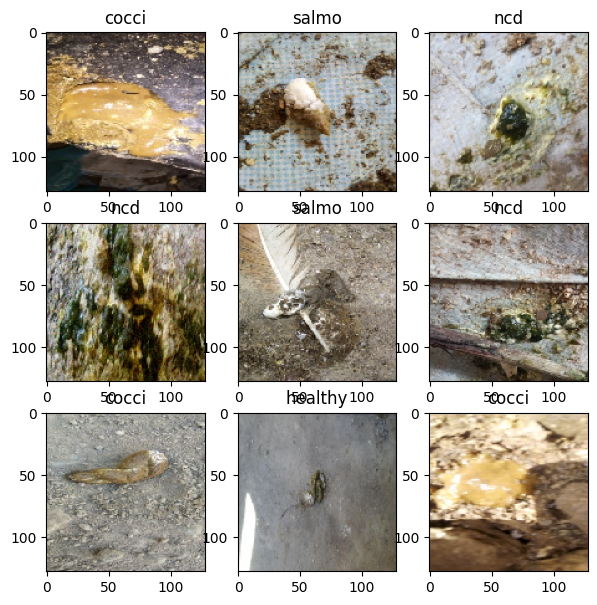

In [15]:
# show some image sample in training dataset
images, labels_class = next(train_dataset)
classes = train_dataset.class_indices
plt.figure(figsize=(7, 7))
for i in range(9):
    label = [j for j in classes if classes[j] == np.argmax(labels_class[i])][0]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i]*255.).astype("uint8"))
    plt.title(label)

In [16]:
# Recheck after rescale
print(images[0].max())
print(images[0].min())

1.0
0.0


---

03. CNN Model Training
   ---

In [17]:
# Training model
# Compile the model
model = Sequential()

# Input layer
model.add(Conv2D(16,(3,3), activation='relu',
                 kernel_initializer='he_uniform', 
                 padding='same', input_shape=(128,128,3))) # filter image by dot product in matrix to find the object in picture
# Hidden layers
model.add(MaxPooling2D(pool_size=(2,2))) # reduce stucture of image even if object slightly move but the result is same  
model.add(Conv2D(32,(3,3), activation='relu',
                 kernel_initializer='he_uniform', 
                 padding='same')) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten()) # convert all the resultant 2-Dimensional arrays into a single long continuous linear vector
model.add(Dense(64, activation='relu',
                kernel_initializer='he_uniform'))

# avoid overfitting!
model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation='softmax'))

# Compile the model         
model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [18]:
# we have 2,102,564 nodes for training
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2

In [20]:
# Save checkpoints during training
checkpoint_path = "model/cnn/cnn_model_cp/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [21]:
# training model 
# make sure you truely save checkpoint_path
history = model.fit(train_dataset,
                              epochs=25,
                              validation_data=valid_dataset,
                              callbacks=[cp_callback])

Epoch 1/25
156/156 [==============================] - ETA: 0s - loss: 1.8422 - accuracy: 0.3319
Epoch 1: saving model to model/cnn/cnn_model_cp\cp.ckpt
156/156 [==============================] - 37s 231ms/step - loss: 1.8422 - accuracy: 0.3319 - val_loss: 1.1922 - val_accuracy: 0.5420
Epoch 2/25
156/156 [==============================] - ETA: 0s - loss: 1.2067 - accuracy: 0.3926
Epoch 2: saving model to model/cnn/cnn_model_cp\cp.ckpt
156/156 [==============================] - 34s 215ms/step - loss: 1.2067 - accuracy: 0.3926 - val_loss: 0.9862 - val_accuracy: 0.7206
Epoch 3/25
156/156 [==============================] - ETA: 0s - loss: 1.1674 - accuracy: 0.4189
Epoch 3: saving model to model/cnn/cnn_model_cp\cp.ckpt
156/156 [==============================] - 32s 207ms/step - loss: 1.1674 - accuracy: 0.4189 - val_loss: 0.9087 - val_accuracy: 0.6415
Epoch 4/25
156/156 [==============================] - ETA: 0s - loss: 1.1452 - accuracy: 0.4392
Epoch 4: saving model to model/cnn/cnn_model_c

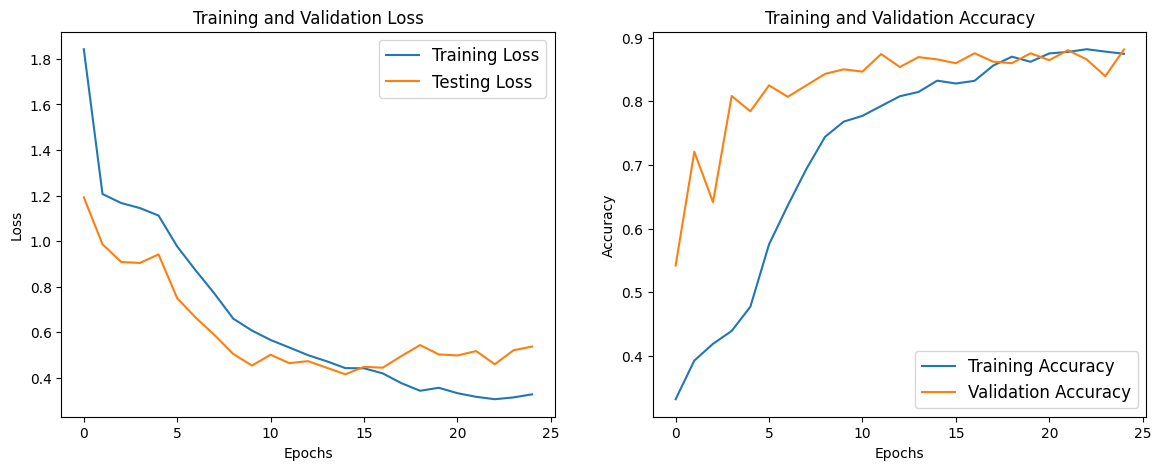

In [22]:
# plot graph 
plot_graph(history)

In [23]:
# create dataframe to save in .csv file
hist_df = pd.DataFrame(history.history) 
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.842190,0.331915,1.192194,0.541966
1,1.206748,0.392627,0.986241,0.720623
2,1.167424,0.418922,0.908690,0.641487
3,1.145169,0.439160,0.904330,0.808153
4,1.112388,0.477185,0.941952,0.784173


In [24]:
# save model
model.save("model/cnn/cnn_model.h5")

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
# save history our model to csv: 
hist_csv_file = 'model/cnn/history_cnn16.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

---